Populating the interactive namespace from numpy and matplotlib
[(37.9676689, 23.72920298), (37.9682968, 23.729191), (37.9686369, 23.7317783), (37.9720792, 23.733686), (37.9758167, 23.7356097), (37.9755988, 23.7346204), (37.9763044, 23.7287133), (37.9762192, 23.7267812), (37.9765965, 23.725825), (37.9747424, 23.7247172), (37.9767907, 23.7259763), (37.9671963, 23.7284495), (37.9685356, 23.727942), (37.9688762, 23.7281395), (37.9701252, 23.7285451), (37.9717563, 23.72589367), (37.9720922, 23.7289803), (37.9667664, 23.7278716), (37.9713652, 23.7236495), (37.9758867, 23.7241544), (37.9772489, 23.7231517), (37.9704348, 23.7198505), (37.9743998, 23.7196783), (37.9693647, 23.723635), (37.9692997, 23.7329933), (37.967217, 23.7284915), (37.9672278, 23.7284826), (37.9672084, 23.7284791), (37.9672257, 23.7284896), (37.9672105, 23.7284766), (37.9672144, 23.7284955), (37.9672177, 23.7284984), (37.9671985, 23.7284931), (37.9672202, 23.7285048), (37.9672049, 23.7285091), (37.9672243, 23.7284976), (37.

`%matplotlib` prevents importing * from pylab and numpy


RuntimeError: no system list, errno: 2


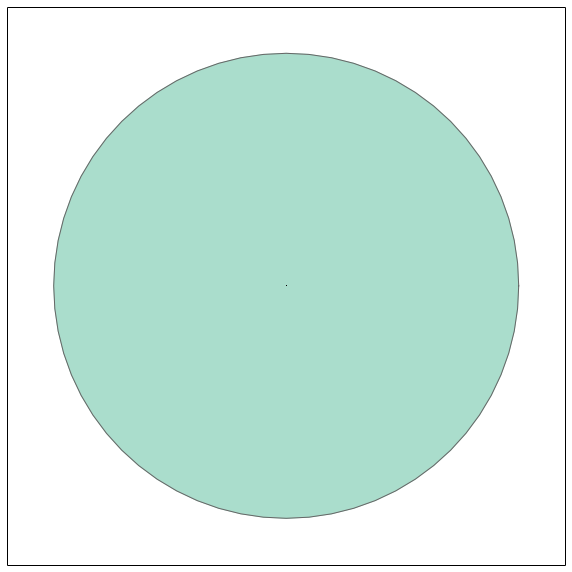

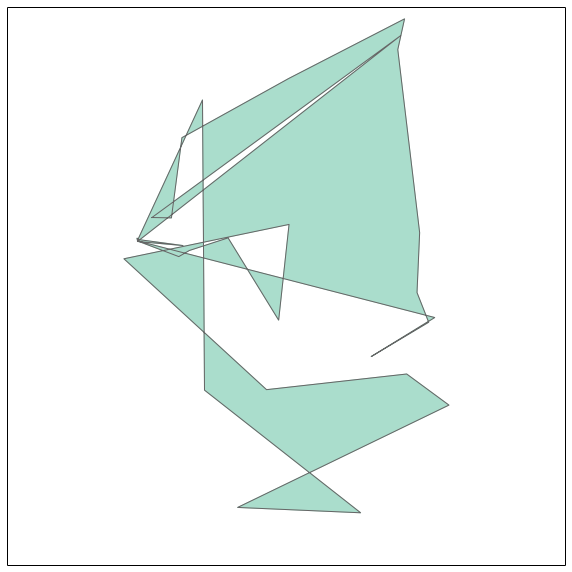

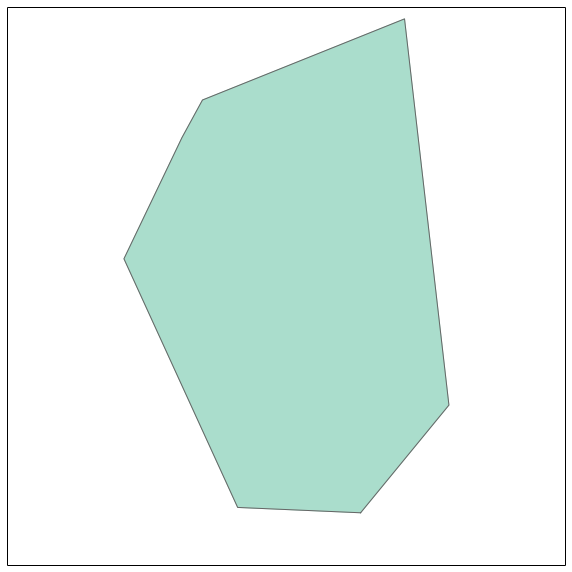

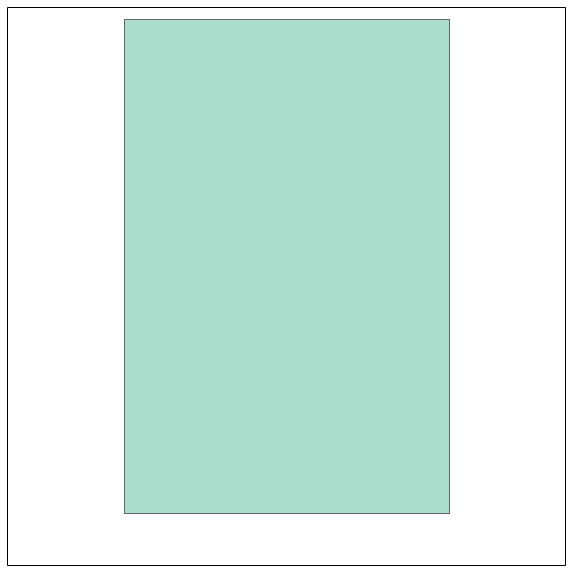

In [75]:
%pylab inline

import os
from osgeo import ogr, osr
import numpy as np

from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import pysal
import pylab as pl
import shapely
import shapely.geometry
import shapely.wkt
from shapely.ops import transform
from shapely.geometry import mapping, shape, Point, LineString, Polygon, MultiPolygon, box, MultiPoint
from shapely.wkt import dumps, loads
from functools import partial
import pyproj
from pyproj import _proj 

import fiona

import random
#grab a random color for coloring a figure
def get_random_color():
    r = lambda: random.randint(0,255)
    return('#%02X%02X%02X' % (r(),r(),r()))

#initialize the figure and draw the shape
def plot(shapelyGeometries, color_dict={"fill":"#AADDCC", "line":"#666666","hole_fill":"#ffffff", "hole_line":"#999999" }):
    'Plot shapelyGeometries'
    figure = pl.figure(num=None, figsize=(10, 10), dpi=180)
    axes = pl.axes()
    axes.set_aspect('equal', 'datalim')
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    
    draw(shapelyGeometries, color_dict)
            
#Check the type and break up multipolygons        
def draw(gs, color_dict):
    'Draw shapelyGeometries'
    # Handle single and lists of geometries
    try:
        gs = iter(gs)
    except TypeError:
        gs = [gs]
    #Route polygons and multipolygons to the right place
    for g in gs:
        gType = g.geom_type
        if gType.startswith('Multi') or gType == 'GeometryCollection':
            draw(g.geoms, color_dict)
        else:
            draw_(g, color_dict)

#Break the shape into its interior and exterior rings            
def draw_(g, color_dict):

    'Draw a shapelyGeometry; thanks to Sean Gilles'
    gType = g.geom_type
    if gType == 'Point':
        pl.plot(g.x, g.y, 'k,')
    elif gType == 'LineString':
        x, y = g.xy
        pl.plot(x, y, 'b-', color=color_dict["line"])
    elif gType == 'Polygon':
        #can draw parts as multiple colors
        if not color_dict:
            color_dict={"fill":get_random_color(), 
                        "line":"#666666",
                        "hole_fill":"#FFFFFF", 
                        "hole_line":"#999999" }
    
    
        x, y = g.exterior.xy
        pl.fill(x, y, color=color_dict["fill"], aa=True) 
        pl.plot(x, y, color=color_dict["line"], aa=True, lw=1.0)
        for hole in g.interiors:
            x, y = hole.xy
            pl.fill(x, y, color=color_dict["hole_fill"], aa=True) 
            pl.plot(x, y, color=color_dict["hole_line"], aa=True, lw=1.0)


pt = Point(0, 0)

circle = pt.buffer(.5)
plot([circle, pt])

#print circle


with open("/Users/carygreenwood/Documents/Data_Science/JIRA/ha/clustering_tests/greece_points.txt", "r") as ins:
    data = []
    
    read = ins.read().splitlines()
    
    for line in read:
        a = line.strip().split('\t')
        #a = a.split('\n')
        #print a, len(a)
        data.append(a)
#print data
latlon = []        
points = []

listExtract = [0 ,1]
ll = [[l[i] for i in listExtract] for l in data]

for lat in (i[0:2] for i in ll):
    coords = float(lat[0]), float(lat[1])
    latlon.append(coords)
    
print latlon

polygon = Polygon(latlon)
#ll_box = box(latlon)

bnds = polygon.bounds
b = box(bnds[0], bnds[1], bnds[2], bnds[3])


ch = MultiPoint(latlon).convex_hull
#ch_wkt = ch.wkt

#ccluster = ogr.CreateGeometryFromWkt(ch_wkt)

"""
# Spatial Reference System
inputEPSG = 3857
outputEPSG = 4326

# create coordinate transformation
inSpatialRef = osr.SpatialReference()
inSpatialRef.ImportFromEPSG(inputEPSG)

outSpatialRef = osr.SpatialReference()
outSpatialRef.ImportFromEPSG(outputEPSG)

coordTransform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

# transform point
point.Transform(coordTransform)
"""

#wgs84 = pyproj.Proj(init='espg:4326')

#convex_wgs84 = pyproj.transform(wgs84, ch)

#print point
#poly = Polygon(data)
#x,y = poly.exterior.xy

print "Our Cluster:"
print polygon

print "Our Cluster's convex hull:"
print ch

print "Cluster bounds:"
print bnds
print b


plot(polygon)
plot(ch)
plot(b)

project = partial(
    pyproj.transform,
    pyproj.Proj(init='espg:3857'),
    pyproj.Proj(init='espg:4326'))

projected_geometry = transform(project,ch)


# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Write a new Shapefile
with fiona.open('cluster.shp', 'w', 'ESRI Shapefile', schema) as c:
    ## If there are multiple geometries, put the "for" loop here
    c.write({
        'geometry': mapping(ch),
        'properties': {'id': 123},
    })
    

In [70]:
type(ccluster)


osgeo.ogr.Geometry